# Project 3


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 50% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).

• The project must be carried out in the groups assigned.
• Use clear and rigorous procedures.
• The delivery of the project is on August 1st, 2021, 11:59 pm, through Bloque Neón.
• No projects will be received after the delivery time or by any other means than the one established. 




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [30]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression 

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [5]:
print(dataTraining.shape,dataTesting.shape )

(7895, 5) (3383, 3)


#### Limpieza y preprocesamiento de los datos

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
#stopword list to use
eng_stopwords = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
#english stemmer
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Limpieza de datos

In [7]:
import re

def clean_text(text):
    text = re.sub("\'", "", text)  
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = text.lower()    
    return text
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: clean_text(x))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: clean_text(x))

In [8]:
from string import digits

def eliminate_numbers(texto):
    remove_digits = str.maketrans('', '', digits)
    texto = texto.translate(remove_digits)

    return texto

dataTraining['plot'] = dataTraining['plot'].apply(lambda x: eliminate_numbers(x))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: eliminate_numbers(x))

In [9]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

dataTraining['plot'] = dataTraining['plot'].apply(lambda x: tokenization(x.lower()))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: tokenization(x))

In [10]:
def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text

dataTraining['plot'] = dataTraining['plot'].apply(lambda x: stemming(x))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: stemming(x))

In [11]:
dataTraining['plot']=[" ".join(plot) for plot in dataTraining['plot'].values]
#dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

dataTesting['plot']=[" ".join(plot) for plot in dataTesting['plot'].values]

### Create count vectorizer


In [12]:
vect = CountVectorizer(max_features=5000, stop_words='english')
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 5000)

In [13]:
print(vect.get_feature_names()[:50])

vect.vocabulary_

['aaron', 'abandon', 'abbi', 'abbott', 'abduct', 'abe', 'abigail', 'abil', 'abl', 'aboard', 'abort', 'abov', 'abraham', 'abrupt', 'absenc', 'absent', 'absolut', 'absorb', 'abus', 'academ', 'academi', 'accept', 'access', 'accid', 'accident', 'acclaim', 'accompani', 'accomplic', 'accomplish', 'accord', 'account', 'accur', 'accus', 'ace', 'achiev', 'acquaint', 'acquir', 'act', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'ad', 'adam', 'adapt', 'add', 'addict', 'addit']


{'stori': 4284,
 'singl': 4085,
 'father': 1661,
 'year': 4980,
 'old': 3153,
 'son': 4167,
 'work': 4949,
 'railroad': 3594,
 'bridg': 551,
 'day': 1134,
 'befor': 396,
 'boy': 519,
 'meet': 2847,
 'woman': 4940,
 'board': 483,
 'train': 4594,
 'drug': 1373,
 'abus': 18,
 'goe': 1905,
 'engin': 1503,
 'room': 3838,
 'tell': 4459,
 'stay': 4260,
 'edg': 1424,
 'nearbi': 3035,
 'lake': 2539,
 'ship': 4040,
 'come': 888,
 'lift': 2630,
 'suppos': 4374,
 'arriv': 244,
 'hour': 2167,
 'later': 2557,
 'happen': 2015,
 'tri': 4619,
 'warn': 4857,
 'abl': 8,
 'just': 2457,
 'approach': 214,
 'fall': 1636,
 'gear': 1862,
 'attempt': 282,
 'lower': 2699,
 'leav': 2585,
 'horrif': 2157,
 'choic': 767,
 'crush': 1073,
 'peopl': 3302,
 'complet': 917,
 'fact': 1626,
 'die': 1244,
 'save': 3918,
 'addict': 48,
 'look': 2674,
 'window': 4923,
 'movi': 2984,
 'end': 1495,
 'man': 2752,
 'wander': 4848,
 'new': 3064,
 'citi': 793,
 'longer': 2672,
 'hold': 2124,
 'small': 4123,
 'babi': 319,
 'narrat'

### Create y

In [14]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [15]:
#np.set_printoptions(threshold=np.inf)
y_genres.shape

(7895, 24)

In [16]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

### Create TfidfVectorizer embeding

In [39]:
vect = TfidfVectorizer(max_features=10000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

### Create universal-sentence-encoder Embeding

In [17]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_hub as hub

In [18]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

In [19]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    sentences_embeddings = session.run(embed(dataTraining.iloc[:4,2]))

sentences_embeddings

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


array([[ 0.02778931,  0.05165495, -0.03457217, ...,  0.04291714,
         0.02114748, -0.04434698],
       [ 0.02412991,  0.02563199,  0.09837525, ..., -0.04429353,
        -0.01280188,  0.0613174 ],
       [ 0.00805342,  0.0446467 , -0.00856222, ...,  0.00414221,
        -0.00034475,  0.00073726],
       [ 0.01638537, -0.01226815, -0.04377961, ...,  0.04372295,
        -0.02820507,  0.00970711]], dtype=float32)

In [ ]:
sentences_embeddings.shape

In [ ]:
dataTraining.iloc[:5,2]

sentences_embeddings = session.run(embed(dataTraining['plot']))

In [ ]:
dataTraining['plot'].shape

### LSTM Model

In [20]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [21]:
from livelossplot import PlotLossesKeras
%matplotlib inline

In [22]:
X = dataTraining['plot'].tolist()

# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [23]:
# Max len
max_url_len = 1500
X = [x[:max_url_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [24]:
X_pad = sequence.pad_sequences(X, maxlen=max_url_len)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_genres, test_size=0.33, random_state=42)

In [28]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_url_len))
model.add(LSTM(21, dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(24, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 128)         3584      
_________________________________________________________________
lstm_1 (LSTM)                (None, 21)                12600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                528       
Total params: 16,712
Trainable params: 16,712
Non-trainable params: 0
_________________________________________________________________


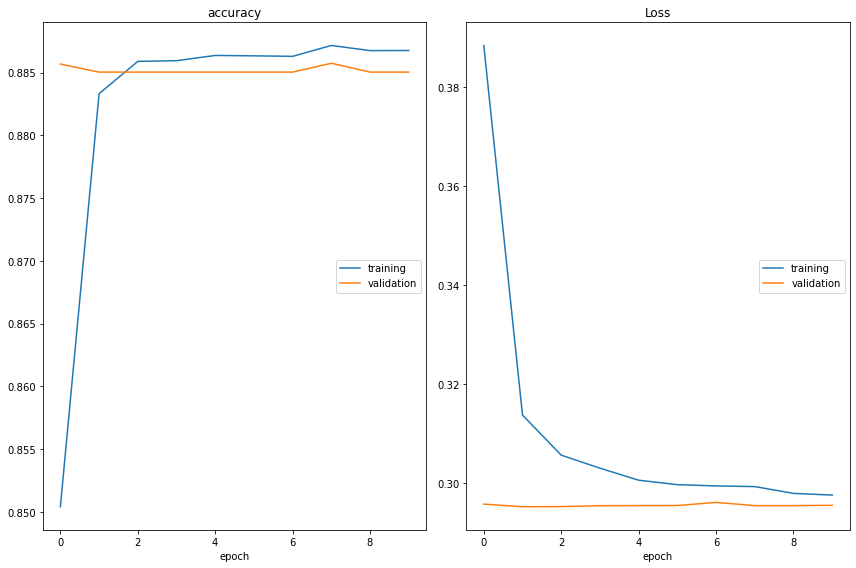

accuracy
	training         	 (min:    0.850, max:    0.887, cur:    0.887)
	validation       	 (min:    0.885, max:    0.886, cur:    0.885)
Loss
	training         	 (min:    0.298, max:    0.388, cur:    0.298)
	validation       	 (min:    0.295, max:    0.296, cur:    0.296)
5289/5289 [==============================] - 442s 84ms/sample - loss: 0.2976 - accuracy: 0.8868 - val_loss: 0.2955 - val_accuracy: 0.8850


In [29]:
model.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size=24, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])

### Train multi-class multi-label model

In [31]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [32]:
clf2 = OneVsRestClassifier(XGBClassifier(learning_rate=0.1, colsample_bytree=0.5, gamma=4, random_state=1))

In [ ]:
clf3 = OneVsRestClassifier(Ridge(alpha=0.91, random_state=1))

In [36]:
clf4 = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs', random_state=1))

In [ ]:
clf5 = OneVsRestClassifier()

In [40]:
clf4.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(random_state=1))

In [41]:
y_pred_genres = clf4.predict_proba(X_test)

In [42]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8821772445745246

XGBOOST
0.8322904445257068 3000
0.8370858273198462 5000
0.8349239191172151 6000
0.8357325213603479 8000
0.8359804782058201 10000
0.8352049238720696 15000


0.8377707509739535  tdfi 5000
0.8408335904630877  tdfi 10000
0.8380609512282696  tdfi 13000
0.8407845000288764  tdfi 17000
0.839989819706268   tdfi 26000

### Modelo Final

In [ ]:
clf_final = OneVsRestClassifier(XGBClassifier(learning_rate=0.1, colsample_bytree=0.5, gamma=4, random_state=1))

#X_dtm = vect.fit_transform(dataTraining['plot'])
#y_genres = le.fit_transform(dataTraining['genres'])

clf_final.fit(X_dtm, y_genres)

In [ ]:
y_pred_genres = clf_final.predict_proba(X_test)

### Predict the testing dataset

In [ ]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf_final.predict_proba(X_test_dtm)

In [ ]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [ ]:
res.head()

In [ ]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')